# Sentiment Analysis con Redes Neuronales

## Pasos Previos

### Carga de datos en el entorno de ejecución

Antes de nada, y ya que he utilizado un Colab, tengo que crear y copiar todos los archivos que necesito, y moverlos a los directorios apropiados.

In [0]:
!mkdir data
!mkdir data/glove_word_embeddings
!mkdir datasets
!mkdir results

Hay que subir:

```glove.6B.50d.txt```

`resultados_modelos.csv`

`sentiment_dataset_limpio.csv`  

`train_sentiment_small.csv`



In [0]:
#antes de ejecutar esto tienes que subir el archivo datasets al notebook

!mv glove.6B.50d.txt data/glove_word_embeddings

In [0]:
!mv resultados_modelos.csv results

In [0]:
!mv train_sentiment_small.csv datasets
!mv sentiment_dataset_limpio.csv datasets
!mv train_sentiment_utf8.csv datasets

### Imports

In [0]:
import pickle
import json
import os
import csv

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import io
from sklearn.metrics import confusion_matrix

from random import sample

from sklearn.model_selection import StratifiedShuffleSplit

from keras.models import Model
from keras.layers import Input

import warnings
warnings.filterwarnings('ignore')

In [0]:
import numpy as np
from keras.layers import Conv1D, Conv2D, SimpleRNN, LSTM, Dense, Dropout
from keras.models import Sequential

Using TensorFlow backend.


In [0]:
from sklearn.model_selection import train_test_split             
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers

### Variables de Entorno

In [0]:
NUM_WORDS = 5000
maxlen = 40 # de los embeddings
embedding_dim_glove = 50
embedding_layer_dim = 100
THRESHOLD = 0.5
RESULTS_FILE = 'results/resultados_modelos.csv'

### Funciones Auxiliares

Aqui defino unas funciones auxiliares para calcular metricas y presentar resultadios.

In [0]:
def add_row(df, row):
    df.loc[-1] = row
    df.index = df.index + 1  
    return df.sort_index()

In [0]:
def convertir_prediccion_en_array(prediccion):
    i = 0

    resp = []
    while i < len(prediccion):
        if prediccion[i] >= THRESHOLD:
            e = 1.0
        else:
            e = 0.0
        resp.append(e)
        i += 1
    return resp


In [0]:
def plot_confusion_matrix(confmat):
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.5)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

    plt.xlabel('predicted label')
    plt.ylabel('true label')

    plt.tight_layout()
    plt.show()

In [0]:
def calcula_metricas(confmat, plot=True):
    
    tn, fp, fn, tp = confmat.ravel()

    acc = (tp+tn)/(tn + fp + fn + tp)
    sen = tp/(tp+fn)
    esp = tn/(tn+fp)
    ppv = tp/(tp+fp)
    fsc = 2*(sen*ppv/(sen+ppv))

    print('ACC: ', acc)
    print('SEN: ', sen)
    print('ESP: ', esp)
    print('PPV: ', ppv)
    print('FSC: ', fsc)

    if plot:
        plt.bar(range(5),[acc,sen,esp,ppv,fsc])
        plt.xticks(range(5),['ACC','SEN','ESP','PPV','FSC'])
        plt.plot([-1, 6], [1, 1], color=(0.6, 0.6, 0.6), linestyle='--')
        plt.xlim((-0.5,4.5))
        plt.ylim((0,1.1))
        plt.title('Metricas')
        plt.show()
    
    metricas = [acc, sen,esp,ppv,fsc]
    return metricas

## Carga y preparación de datos

Cargo el dataset pequeño. Esto es debido a que por incompatibilidad de alguna de las capas usadas con la GPU que tiene Colab, no se puede trabajar en GPU, con lo que para entrenar en un tiempo apropiado, uso un dataset pequeño (sacado de la sección 1.1)

In [0]:
df = pd.read_csv('datasets/train_sentiment_small.csv')

# Descomentar para entrenar con el conjunto grande
#df = pd.read_csv('datasets/sentiment_dataset_limpio.csv')

In [0]:
df = df.drop(['Unnamed: 0'], axis=1)

In [0]:
df.head(5)

,Sentiment,SentimentText
0,1,<MENTION> lol ok thanks. anyway watcha doing?
1,1,"<MENTION> -- yeah, thank ya kindly!"
2,0,"<MENTION>, is being a horrible friend. tears."
3,0,Jonas Brothers 3D Concert Movie is out on the ...
4,1,<MENTION> k just call asap


In [0]:
import re
def replace_re (cad, regex, token):
    return re.sub(regex, token, cad)

In [0]:
sentiment_text = df['SentimentText'].values

In [0]:
y = df['Sentiment'].values

In [0]:
sentiment_train,sentiment_test,y_train,y_test = train_test_split(
                                                sentiment_text, y,  
                                                test_size=0.25,  
                                                random_state=42)

## Embedding

In [0]:
tokenizer = Tokenizer(num_words=NUM_WORDS)
tokenizer.fit_on_texts(sentiment_train)

In [0]:
X_train = tokenizer.texts_to_sequences(sentiment_train)
X_test = tokenizer.texts_to_sequences(sentiment_test)

In [0]:
# Adding 1 because of  reserved 0 index
vocab_size = len(tokenizer.word_index) + 1 

In [0]:
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

Para generar los Word Embeddings uso [Glove](https://en.wikipedia.org/wiki/GloVe_(machine_learning)), que es un conjunto preentrenado de word embeddings.

*GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.*

In [0]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  
    # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [0]:
embedding_matrix = create_embedding_matrix('data/glove_word_embeddings/glove.6B.50d.txt' ,
                                            tokenizer.word_index,  
                                            embedding_dim_glove)

## Red Neuronal Convolucional

In [0]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_layer_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 40, 100)           1155100   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 36, 128)           64128     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 1,220,529
Trainable params: 1,220,529
Non-trainable params: 0
_________________________________________________________________


Con todo el dataset se tarda un rato en entrenar (aprox 8 minutos por época), con el dataset pequeño 5s por época.

In [0]:
from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor='loss', min_delta=0, patience=5, verbose=0, mode='auto')

In [0]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    validation_data=(X_test, y_test),
                    batch_size=16
                    callbacks=[earlystop])

Train on 7500 samples, validate on 2500 samples
Epoch 1/50
7500/7500 [==============================] - 5s 611us/step - loss: 0.5906 - acc: 0.6736 - val_loss: 0.5322 - val_acc: 0.7264
Epoch 2/50
7500/7500 [==============================] - 4s 552us/step - loss: 0.4060 - acc: 0.8172 - val_loss: 0.5728 - val_acc: 0.7152
Epoch 3/50
7500/7500 [==============================] - 4s 547us/step - loss: 0.2200 - acc: 0.9199 - val_loss: 0.6752 - val_acc: 0.7248
Epoch 4/50
7500/7500 [==============================] - 4s 543us/step - loss: 0.0929 - acc: 0.9729 - val_loss: 0.7877 - val_acc: 0.7160
Epoch 5/50
7500/7500 [==============================] - 4s 541us/step - loss: 0.0378 - acc: 0.9888 - val_loss: 1.0169 - val_acc: 0.7152
Epoch 6/50
7500/7500 [==============================] - 4s 542us/step - loss: 0.0222 - acc: 0.9927 - val_loss: 1.1328 - val_acc: 0.7216
Epoch 7/50
7500/7500 [==============================] - 4s 538us/step - loss: 0.0171 - acc: 0.9941 - val_loss: 1.2559 - val_acc: 0.7044


In [0]:
# Evaluamos
train_acc = model.evaluate(X_train, y_train)[1]
prediction = model.predict(X_test)

7500/7500 [==============================] - 1s 68us/step


In [0]:
# Para poder usar las funciones de matriz de confusion y demás

prediccion = convertir_prediccion_en_array(prediction)

In [0]:
confmat = confusion_matrix(y_test, prediccion)

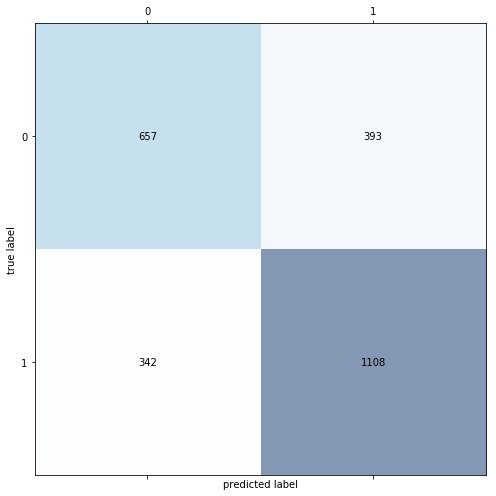

In [0]:
plot_confusion_matrix(confmat)


In [0]:
metricas = calcula_metricas(confmat, plot=False)

ACC:  0.706
SEN:  0.7641379310344828
ESP:  0.6257142857142857
PPV:  0.7381745502998002
FSC:  0.7509318874957642


In [0]:
test_acc = metricas[0]

In [0]:
resultadosModelo = pd.read_csv(RESULTS_FILE)
resultadosModelo = resultadosModelo.drop(['Unnamed: 0'], axis=1)

In [0]:
resultado = ['CNN - Small Dataset', '-', train_acc, test_acc, confmat, metricas]

In [0]:
add_row(resultadosModelo, resultado)

,Modelo,parametros-optimos,train,test,confusion_matrix,acc_sen_esp_ppv_fsc
0,CNN - Small Dataset,-,0.996800,0.706000,"[[657, 393], [342, 1108]]","[0.706, 0.7641379310344828, 0.6257142857142857..."
1,SVM - Small Dataset,"{'svm__C': 5.994842503189409, 'svm__gamma': 0....",0.716000,0.733000,[[ 799 507]\n [ 294 1400]],"[0.733, 0.8264462809917356, 0.611791730474732,..."
2,Bayes - Small Dataset,"{'vect__analyzer': 'char', 'vect__max_df': 1.0...",0.717000,0.722333,[[ 909 397]\n [ 436 1258]],"[0.7223333333333334, 0.7426210153482881, 0.696..."
3,Decision Tree - Small Dataset,"{'tree__max_depth': 19, 'vect__analyzer': 'wor...",0.653286,0.649667,[[ 479 827]\n [ 224 1470]],"[0.6496666666666666, 0.8677685950413223, 0.366..."
4,Random Forestyes - Small Dataset,"{'forest__max_depth': 23, 'vect__analyzer': 'c...",0.668857,0.665000,[[ 630 676]\n [ 329 1365]],"[0.665, 0.8057851239669421, 0.4823889739663093..."
5,Boosted Tree - Small Dataset,"{'boosted__learning_rate': 0.1, 'boosted__max_...",0.714857,0.728667,[[ 784 522]\n [ 292 1402]],"[0.7286666666666667, 0.8276269185360094, 0.600..."
6,Bayes - Lemma - Small Dataset,"{'vect__analyzer': 'word', 'vect__max_df': 0.5...",0.686670,0.690333,[[ 704 602]\n [ 327 1367]],"[0.6903333333333334, 0.806965761511216, 0.5390..."
7,Decision Tree - Lemma - Small Dataset,"{'tree__max_depth': 19, 'vect__analyzer': 'wor...",0.650236,0.647333,[[ 362 944]\n [ 114 1580]],"[0.6473333333333333, 0.9327036599763873, 0.277..."
8,Random Forestyes - Lemma - Small Dataset,"{'forest__max_depth': 28, 'vect__analyzer': 'c...",0.660237,0.664667,[[ 562 744]\n [ 262 1432]],"[0.6646666666666666, 0.8453364817001181, 0.430..."
9,Boosted Tree - Lemma - Small Dataset,"{'boosted__learning_rate': 0.1, 'boosted__max_...",0.686955,0.701333,[[ 692 614]\n [ 282 1412]],"[0.7013333333333334, 0.833530106257379, 0.5298..."


In [0]:
resultadosModelo.to_csv(RESULTS_FILE)

## LSTM

### Primer Intento

MI primer intento ha sido pasarle directamente la matriz de embeddings calculada para la CNN y ver que pasaba.

In [0]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_layer_dim, input_length=maxlen))
model.add(layers.LSTM(200))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 40, 100)           1155100   
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               240800    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 201       
Total params: 1,396,101
Trainable params: 1,396,101
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    validation_data=(X_test, y_test),
                    batch_size=16,
                    callbacks=[earlystop])

Train on 7500 samples, validate on 2500 samples
Epoch 1/50
7500/7500 [==============================] - 50s 7ms/step - loss: 0.6831 - acc: 0.5593 - val_loss: 0.6694 - val_acc: 0.5800
Epoch 2/50
7500/7500 [==============================] - 49s 6ms/step - loss: 0.6594 - acc: 0.5548 - val_loss: 0.6683 - val_acc: 0.5324
Epoch 3/50
7500/7500 [==============================] - 48s 6ms/step - loss: 0.6685 - acc: 0.5540 - val_loss: 0.6703 - val_acc: 0.5800
Epoch 4/50
7500/7500 [==============================] - 48s 6ms/step - loss: 0.6664 - acc: 0.5523 - val_loss: 0.6666 - val_acc: 0.5800
Epoch 5/50
7500/7500 [==============================] - 48s 6ms/step - loss: 0.6658 - acc: 0.5529 - val_loss: 0.6777 - val_acc: 0.4796
Epoch 6/50
7500/7500 [==============================] - 48s 6ms/step - loss: 0.6641 - acc: 0.5556 - val_loss: 0.6753 - val_acc: 0.5800
Epoch 7/50
7500/7500 [==============================] - 48s 6ms/step - loss: 0.6598 - acc: 0.5528 - val_loss: 0.6772 - val_acc: 0.5800


Lo que pasa es que la red neuronal no aprende, enseguida todos los valores de salida convergen en 1, y en cuanto llega ahi no sale.

In [0]:
# Evaluamos
train_acc = model.evaluate(X_train, y_train)[1]
prediction = model.predict(X_test)

7500/7500 [==============================] - 8s 1ms/step


In [0]:
def convertir_prediccion_en_entero(prediccion):
    i = 0
    resp = []
    while i < len(prediccion):
        resp.append(int(prediccion[i]))
        i += 1
    return resp

In [0]:
prediccion = convertir_prediccion_en_array(prediction)
prediccion2 = convertir_prediccion_en_entero(prediccion)

In [0]:
confmat = confusion_matrix(y_test, prediccion2)

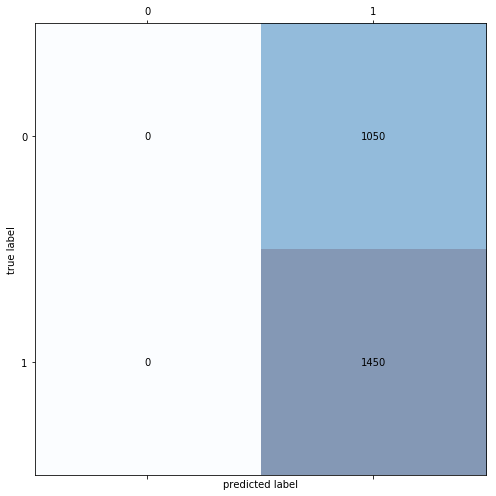

In [0]:
plot_confusion_matrix(confmat)

### ¿Qué está pasando aqui?

Mi primer impulso ha sido pensar que la red estaba mal montada, y he dado muchas vueltas tanto a la red como a la parte de los embeddings. 

Incluso he sido tentado por hacerlo a mano....

![Neural Network](https://imgs.xkcd.com/comics/trained_a_neural_net_2x.png)

Pero no... la respuesta era [otra](https://en.wikipedia.org/wiki/Garbage_in,_garbage_out).

![GIGO](https://candysdirt.com/wp-content/uploads/2016/05/Garbage-In-Garbage-Out.jpg)
.


Después de mucho (MUCHO) enredar, he echado un vistazo a los wordembeddings y el Tokenizador, y me he dado cuenta que muchas filas empezaban con 1, es decir, la palabra `< MENTION >` del dataset. Esto mismo pasa con la palabra `< HASHTAG>`

Cuando he entrenado el modelo habiendo quitado esas palabras, por fín convergía a un resultado apropiado.


In [0]:
# quitar <MENTION>
mention_re = r'<MENTION>'
df['SentimentText'] = df['SentimentText'].apply(lambda x: replace_re(x, mention_re, "")) 

hashtag_re = r'<HASHTAG>'
df['SentimentText'] = df['SentimentText'].apply(lambda x: replace_re(x, hashtag_re, "")) 


# quitar espacios antes y despues del texto (los que se hayan podido meter despues de las sustituciones)
df['SentimentText'] = df['SentimentText'].map(lambda SentimentText: SentimentText.strip())  

In [0]:
sentiment_text = df['SentimentText'].values
y = df['Sentiment'].values
sentiment_train,sentiment_test,y_train,y_test = train_test_split(
                                                sentiment_text, y,  
                                                test_size=0.25,  
                                                random_state=42)

In [0]:
tokenizer = Tokenizer(num_words=NUM_WORDS)
tokenizer.fit_on_texts(sentiment_train)

In [0]:
X_train = tokenizer.texts_to_sequences(sentiment_train)
X_test = tokenizer.texts_to_sequences(sentiment_test)

In [0]:
vocab_size = len(tokenizer.word_index) + 1

In [0]:
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [0]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_layer_dim, input_length=maxlen))
model.add(layers.LSTM(200))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

earlystop = EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=0, mode='auto')

In [28]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    validation_data=(X_test, y_test),
                    batch_size=16,
                    callbacks=[earlystop])


Train on 7500 samples, validate on 2500 samples
Epoch 1/50
7500/7500 [==============================] - 54s 7ms/step - loss: 0.6873 - acc: 0.5593 - val_loss: 0.6814 - val_acc: 0.5800
Epoch 2/50
7500/7500 [==============================] - 49s 7ms/step - loss: 0.6860 - acc: 0.5615 - val_loss: 0.6805 - val_acc: 0.5800
Epoch 3/50
7500/7500 [==============================] - 48s 6ms/step - loss: 0.6864 - acc: 0.5609 - val_loss: 0.6726 - val_acc: 0.5696
Epoch 4/50
7500/7500 [==============================] - 48s 6ms/step - loss: 0.6859 - acc: 0.5573 - val_loss: 0.6897 - val_acc: 0.5596
Epoch 5/50
7500/7500 [==============================] - 48s 6ms/step - loss: 0.6859 - acc: 0.5441 - val_loss: 0.6747 - val_acc: 0.5556
Epoch 6/50
7500/7500 [==============================] - 48s 6ms/step - loss: 0.6794 - acc: 0.5493 - val_loss: 0.6748 - val_acc: 0.5800
Epoch 7/50
7500/7500 [==============================] - 48s 6ms/step - loss: 0.6746 - acc: 0.5572 - val_loss: 0.6728 - val_acc: 0.5696
Epoch 

In [29]:
train_acc = model.evaluate(X_train, y_train)[1]
prediction = model.predict(X_test)

7500/7500 [==============================] - 8s 1ms/step


In [0]:
prediccion = convertir_prediccion_en_array(prediction)
prediccion2 = convertir_prediccion_en_entero(prediccion)
confmat = confusion_matrix(y_test, prediccion2)

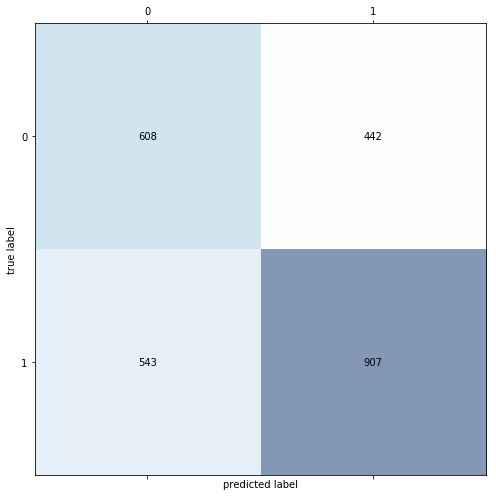

In [36]:
plot_confusion_matrix(confmat)

In [37]:
metricas = calcula_metricas(confmat, plot=False)

ACC:  0.606
SEN:  0.6255172413793103
ESP:  0.579047619047619
PPV:  0.6723498888065234
FSC:  0.6480886030725258


In [0]:
test_acc = metricas[0]

In [0]:
resultadosModelo = pd.read_csv(RESULTS_FILE)
resultadosModelo = resultadosModelo.drop(['Unnamed: 0'], axis=1)

resultado = ['RNN - Small Dataset - Fuera <MENTIONS> y <HASHTAG>', '-', train_acc, test_acc, confmat, metricas]

In [40]:
add_row(resultadosModelo, resultado)

,Modelo,parametros-optimos,train,test,confusion_matrix,acc_sen_esp_ppv_fsc
0,RNN - Small Dataset - Fuera <MENTIONS> y <HASH...,-,0.989733,0.606000,"[[608, 442], [543, 907]]","[0.606, 0.6255172413793103, 0.579047619047619,..."
1,SVM - Small Dataset,"{'svm__C': 5.994842503189409, 'svm__gamma': 0....",0.716000,0.733000,[[ 799 507]\n [ 294 1400]],"[0.733, 0.8264462809917356, 0.611791730474732,..."
2,Bayes - Small Dataset,"{'vect__analyzer': 'char', 'vect__max_df': 1.0...",0.717000,0.722333,[[ 909 397]\n [ 436 1258]],"[0.7223333333333334, 0.7426210153482881, 0.696..."
3,Decision Tree - Small Dataset,"{'tree__max_depth': 19, 'vect__analyzer': 'wor...",0.653286,0.649667,[[ 479 827]\n [ 224 1470]],"[0.6496666666666666, 0.8677685950413223, 0.366..."
4,Random Forestyes - Small Dataset,"{'forest__max_depth': 23, 'vect__analyzer': 'c...",0.668857,0.665000,[[ 630 676]\n [ 329 1365]],"[0.665, 0.8057851239669421, 0.4823889739663093..."
5,Boosted Tree - Small Dataset,"{'boosted__learning_rate': 0.1, 'boosted__max_...",0.714857,0.728667,[[ 784 522]\n [ 292 1402]],"[0.7286666666666667, 0.8276269185360094, 0.600..."
6,Bayes - Lemma - Small Dataset,"{'vect__analyzer': 'word', 'vect__max_df': 0.5...",0.686670,0.690333,[[ 704 602]\n [ 327 1367]],"[0.6903333333333334, 0.806965761511216, 0.5390..."
7,Decision Tree - Lemma - Small Dataset,"{'tree__max_depth': 19, 'vect__analyzer': 'wor...",0.650236,0.647333,[[ 362 944]\n [ 114 1580]],"[0.6473333333333333, 0.9327036599763873, 0.277..."
8,Random Forestyes - Lemma - Small Dataset,"{'forest__max_depth': 28, 'vect__analyzer': 'c...",0.660237,0.664667,[[ 562 744]\n [ 262 1432]],"[0.6646666666666666, 0.8453364817001181, 0.430..."
9,Boosted Tree - Lemma - Small Dataset,"{'boosted__learning_rate': 0.1, 'boosted__max_...",0.686955,0.701333,[[ 692 614]\n [ 282 1412]],"[0.7013333333333334, 0.833530106257379, 0.5298..."


In [0]:
resultadosModelo.to_csv(RESULTS_FILE)

### Mejorando el modelo

In [0]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_layer_dim, input_length=maxlen))
model.add(layers.SpatialDropout1D(0.4))
model.add(layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

earlystop = EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=0, mode='auto')


In [54]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 40, 100)           1155200   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 40, 100)           0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 128)               117248    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 1,272,577
Trainable params: 1,272,577
Non-trainable params: 0
_________________________________________________________________


In [53]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    validation_data=(X_test, y_test),
                    batch_size=16,
                    callbacks=[earlystop])

Train on 7500 samples, validate on 2500 samples
Epoch 1/10
7500/7500 [==============================] - 54s 7ms/step - loss: 0.3484 - acc: 0.8649 - val_loss: 0.6666 - val_acc: 0.7004
Epoch 2/10
7500/7500 [==============================] - 54s 7ms/step - loss: 0.3223 - acc: 0.8740 - val_loss: 0.7602 - val_acc: 0.7048
Epoch 3/10
7500/7500 [==============================] - 54s 7ms/step - loss: 0.2964 - acc: 0.8875 - val_loss: 0.7017 - val_acc: 0.7008
Epoch 4/10
7500/7500 [==============================] - 53s 7ms/step - loss: 0.2717 - acc: 0.9012 - val_loss: 0.7467 - val_acc: 0.7008
Epoch 5/10
7500/7500 [==============================] - 53s 7ms/step - loss: 0.2492 - acc: 0.9059 - val_loss: 0.7612 - val_acc: 0.6988
Epoch 6/10
7500/7500 [==============================] - 52s 7ms/step - loss: 0.2274 - acc: 0.9179 - val_loss: 0.7790 - val_acc: 0.7024
Epoch 7/10
7500/7500 [==============================] - 52s 7ms/step - loss: 0.2176 - acc: 0.9196 - val_loss: 0.7927 - val_acc: 0.7000
Epoch 8

In [55]:
train_acc = model.evaluate(X_train, y_train)[1]
prediction = model.predict(X_test)

7500/7500 [==============================] - 8s 1ms/step


In [0]:
prediccion = convertir_prediccion_en_array(prediction)
prediccion2 = convertir_prediccion_en_entero(prediccion)

confmat = confusion_matrix(y_test, prediccion2)

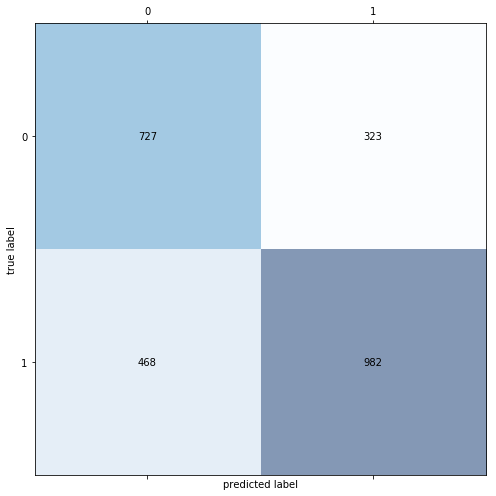

In [57]:
plot_confusion_matrix(confmat)

In [58]:
metricas = calcula_metricas(confmat, plot=False)

ACC:  0.6836
SEN:  0.6772413793103448
ESP:  0.6923809523809524
PPV:  0.7524904214559387
FSC:  0.712885662431942


In [0]:
test_acc = metricas[0]

resultadosModelo = pd.read_csv(RESULTS_FILE)
resultadosModelo = resultadosModelo.drop(['Unnamed: 0'], axis=1)

resultado = ['RNN - SmDst - LSTM con Dropout', '-', train_acc, test_acc, confmat, metricas]

In [0]:
add_row(resultadosModelo, resultado)
resultadosModelo.to_csv(RESULTS_FILE)